# Importing $B \to D^{*+}\mu^-\bar{\nu}_\mu$ Decay Data  
Decay chain: $B \to D^{*+}\mu^-\bar{\nu}_\mu$ then $D^{*+} \to D^0\pi^+$ and $D^0 \to K^+\pi^-$

In [1]:
import uproot
import pandas
import numpy as np
import itertools 
import matplotlib.pyplot as plt
from pylorentz import Momentum4
from lvec import LVec
import os
import pandas as pd
from matplotlib.ticker import AutoMinorLocator, MultipleLocator

    # os.chdir('raw_data/')

mB = 5279.
def bframe_approx(inframe):
    # An approximation for the B momentum in the lab frame
    pz_corr = inframe["B_PZ"] * mB/inframe["B_M"]
    inframe["pz_corr"] = pz_corr
    flightmag = np.sqrt((inframe["B_ENDVERTEX_X"] - inframe["B_OWNPV_X"])**2 + (inframe["B_ENDVERTEX_Y"] - inframe["B_OWNPV_Y"])**2 + (inframe["B_ENDVERTEX_Z"] - inframe["B_OWNPV_Z"])**2)
    cosalpha = (inframe["B_ENDVERTEX_Z"] - inframe["B_OWNPV_Z"])/flightmag # Angle between the flight-direction and the beam line (z)
    inframe["p_corr"] = pz_corr/cosalpha
    tanalphax =  (inframe["B_ENDVERTEX_X"] - inframe["B_OWNPV_X"])/(inframe["B_ENDVERTEX_Z"] - inframe["B_OWNPV_Z"])
    inframe["px_corr"] = pz_corr * tanalphax
    tanalphay =  (inframe["B_ENDVERTEX_Y"] - inframe["B_OWNPV_Y"])/(inframe["B_ENDVERTEX_Z"] - inframe["B_OWNPV_Z"])
    inframe["py_corr"] = pz_corr * tanalphay
    inframe["pe_corr"] = np.sqrt(inframe["p_corr"]**2 + mB**2)


def reco_vars(inframe):
    inframe["reco_q2"] = ((inframe["pe_corr"] - inframe["Dstar_PE"])**2 - (inframe["px_corr"] - inframe["Dstar_PX"])**2 - (inframe["py_corr"] - inframe["Dstar_PY"])**2 - (inframe["pz_corr"] - inframe["Dstar_PZ"])**2)/1.e6
    inframe["missM2"] = ((inframe["pe_corr"] - inframe["Dstar_PE"] - inframe["mu_PE"])**2 - (inframe["px_corr"] - inframe["Dstar_PX"] - inframe["mu_PX"])**2 - (inframe["py_corr"] - inframe["Dstar_PY"] - inframe["mu_PY"])**2 - (inframe["pz_corr"] - inframe["Dstar_PZ"] - inframe["mu_PZ"])**2)/1.e6

def true_vars(inframe):
    inframe["true_q2"] = (inframe["B_TRUEP_E"] - inframe["Dstar_TRUEP_E"])**2 - (inframe["B_TRUEP_X"] - inframe["Dstar_TRUEP_X"])**2 - (inframe["B_TRUEP_Y"] - inframe["Dstar_TRUEP_Y"])**2 - (inframe["B_TRUEP_Z"] - inframe["Dstar_TRUEP_Z"])**2


all_particles = ["B", "Dstar", "D0", "slpi", "Kplus", "piminus", "mu"]
all_list = ["P", "PX", "PY", "PZ", "PE", "TRUEP_E", "TRUEP_X", "TRUEP_Y", "TRUEP_Z", "M"]
br_list = ["%s_%s" % (_p[0], _p[1]) for _p in itertools.product(all_particles, all_list)]

br_list.extend(["B_ENDVERTEX_%s" % _y for _y in ["X","Y","Z"]])
br_list.extend(["B_OWNPV_%s" % _y for _y in ["X","Y","Z"]])

infile = uproot.open("raw_data/Bd_Dstmunu_Dstmu_2016_comb.root")["DecayTree"].arrays(br_list, "(abs(D0_TRUEID)==421) & (abs(Dstar_TRUEID)==413) & (abs(B_TRUEID)==511) & (abs(Dstar_MC_MOTHER_ID)==511) & (abs(mu_MC_MOTHER_ID)==511)", library = 'pd') # Just load 1000 to start with
bframe_approx(infile)
reco_vars(infile)
true_vars(infile)

infile_raw = uproot.open("raw_data/B2Dstmu_11574021_trueTuple.root")["DTTDstmu/MCDecayTree;1"].arrays(library='pd')

# Function Definitions

In [4]:
def lorentz_boost_lvec(mom1, mom2, valid_mask=None):
    if valid_mask is None:
        valid_mask = np.ones(mom1.shape[0], dtype=bool)  

    valid_mom1, valid_mom2 = mom1[valid_mask], mom2[valid_mask]


    p1x, p1y, p1z, E1 = valid_mom1[:, 1], valid_mom1[:, 2], valid_mom1[:, 3], valid_mom1[:, 0]
    p2x, p2y, p2z, E2 = valid_mom2[:, 1], valid_mom2[:, 2], valid_mom2[:, 3], valid_mom2[:, 0]

    mom1_valid = LVec(p1x, p1y, p1z, E1)

    b2_x, b2_y, b2_z = -p2x / E2, -p2y / E2, -p2z / E2

    mom1_boosted = mom1_valid.boost(b2_x, b2_y, b2_z)

    return np.column_stack((mom1_boosted.E, mom1_boosted.px, mom1_boosted.py, mom1_boosted.pz))

def valid_configs(b1,b2,b3):
    beta_sq = b1**2 + b2**2 + b3**2
    valid_mask = beta_sq <= 1

    return valid_mask

def dot(vec1, vec2):
    return np.einsum('ij,ij->i', vec1, vec2)  # Element-wise dot product for each pair of vectors

def cross(vec1, vec2):
    return np.cross(vec1, vec2)  # Element-wise cross product for each pair of vectors


def signed_angle(a, b):
    # Compute the dot product of vectors a and b
    dot_product = np.einsum('ij,ij->i', a, b)

    # Compute the norms of a and b
    norm_a = np.linalg.norm(a, axis=1)
    norm_b = np.linalg.norm(b, axis=1)

    # Compute the cosine of the angle between a and b
    cos_angle = dot_product / (norm_a * norm_b)

    # Clip cos_angle to handle any floating-point precision issues
    cos_angle = np.clip(cos_angle, -1.0, 1.0)

    # Compute the angle in radians using arccos
    angle = np.arccos(cos_angle)

    # Compute the cross product to determine the sign of the angle
    cross_product = np.cross(a, b)

    # Compute the sign of the cross product along the third axis
    sign = np.sign(cross_product[:, 2])

    # Adjust angle to be between 0 and 2π
    angle = np.where(sign >= 0, angle, 2 * np.pi - angle)

    return angle

def invariant_mass_squared(p):
    M2 = []
    for i in range(len(p)):
        M2.append(p[i][0]**2 - p[i][1]**2 - p[i][2]**2 - p[i][3]**2)
    M2 = np.array(M2)
    return M2

### Run this cell always to obtain valid configurations!

In [5]:
B_reco = np.array([infile['pe_corr'], infile['px_corr'], infile['py_corr'], infile['pz_corr']]).T
Dstar_reco = np.array([infile['Dstar_PE'], infile['Dstar_PX'], infile['Dstar_PY'], infile['Dstar_PZ']]).T
mu_reco = np.array([infile['mu_PE'], infile['mu_PX'], infile['mu_PY'], infile['mu_PZ']]).T
nu_reco = B_reco - Dstar_reco - mu_reco
W_reco = B_reco - Dstar_reco
mom1 = mu_reco
mom2 = W_reco
mom3 = nu_reco
mom4 = B_reco

p1x, p1y, p1z, E1 = mom1.T[1], mom1.T[2], mom1.T[3], mom1.T[0]
p2x, p2y, p2z, E2 = mom2.T[1], mom2.T[2], mom2.T[3], mom2.T[0]
p3x, p3y, p3z, E3 = mom3.T[1], mom3.T[2], mom3.T[3], mom3.T[0]
p4x, p4y, p4z, E4 = mom4.T[1], mom4.T[2], mom4.T[3], mom4.T[0]

mom2 = LVec(p2x, p2y, p2z, E2)
mom4 = LVec(p4x, p4y, p4z, E4)

b2_x, b2_y, b2_z = -p2x/E2, -p2y/E2, -p2z/E2
b4_x, b4_y, b4_z = -p4x/E4, -p4y/E4, -p4z/E4

valid_indices = valid_configs(b2_x, b2_y, b2_z)
valid_energy_mask = nu_reco.T[0] >= 0
valid_energy_list = (valid_energy_mask)
future_energy = E3 + (p3x * b4_x + p3y * b4_y + p3z * b4_z)
valid_future_energy_mask = future_energy >= 0

final_valid_mask = ~(~valid_indices | ~valid_energy_mask | ~valid_future_energy_mask)

valid_indices = final_valid_mask

proportion_false = np.mean(~valid_indices)
print(f"Number of configurations: {len(valid_indices)}")
print(f"Proportion of invalid configurations: {proportion_false:.2%}")
print(f"Number of invalid configurations: {np.sum(~valid_indices)}")


Number of configurations: 560001
Proportion of invalid configurations: 2.08%
Number of invalid configurations: 11635


# Four-momenta in the Lab Frame  
B momentum must be approximated and neutrino momentum must be calculated



### **Reconstructed Variables:** (run either this or cell below)

In [6]:
B_momentum_reco = np.array([infile['pe_corr'], infile['px_corr'], infile['py_corr'], infile['pz_corr']]).T
Dstar_momentum_reco = np.array([infile['Dstar_PE'], infile['Dstar_PX'], infile['Dstar_PY'], infile['Dstar_PZ']]).T
mu_momentum_reco = np.array([infile['mu_PE'], infile['mu_PX'], infile['mu_PY'], infile['mu_PZ']]).T
neutrino_momentum_reco = B_momentum_reco - Dstar_momentum_reco - mu_momentum_reco
D0_momentum_reco = np.array([infile['D0_PE'], infile['D0_PX'], infile['D0_PY'], infile['D0_PZ']]).T
slpi_momentum_reco = np.array([infile['slpi_PE'], infile['slpi_PX'], infile['slpi_PY'], infile['slpi_PZ']]).T

W_momentum_reco = B_momentum_reco - Dstar_momentum_reco

### **True Variables:**
Run first with reco variables to obtain the invalid configurations. This will save the invalid indices so that these configurations can also be discarded for the true case also.

In [7]:
B_momentum = np.array([infile['B_TRUEP_E'], infile['B_TRUEP_X'], infile['B_TRUEP_Y'], infile['B_TRUEP_Z']]).T
Dstar_momentum = np.array([infile['Dstar_TRUEP_E'], infile['Dstar_TRUEP_X'], infile['Dstar_TRUEP_Y'], infile['Dstar_TRUEP_Z']]).T
mu_momentum = np.array([infile['mu_TRUEP_E'], infile['mu_TRUEP_X'], infile['mu_TRUEP_Y'], infile['mu_TRUEP_Z']]).T
neutrino_momentum = B_momentum - Dstar_momentum - mu_momentum
D0_momentum = np.array([infile['D0_TRUEP_E'], infile['D0_TRUEP_X'], infile['D0_TRUEP_Y'], infile['D0_TRUEP_Z']]).T
slpi_momentum = np.array([infile['slpi_TRUEP_E'], infile['slpi_TRUEP_X'], infile['slpi_TRUEP_Y'], infile['slpi_TRUEP_Z']]).T

W_momentum = B_momentum - Dstar_momentum

###  **Unselected True Variables**

In [8]:
B_momentum_raw = np.array([infile_raw['B0_TRUEP_E'], infile_raw['B0_TRUEP_X'], infile_raw['B0_TRUEP_Y'], infile_raw['B0_TRUEP_Z']]).T
Dstar_momentum_raw = np.array([infile_raw['Dst_2010_minus_TRUEP_E'], infile_raw['Dst_2010_minus_TRUEP_X'], infile_raw['Dst_2010_minus_TRUEP_Y'], infile_raw['Dst_2010_minus_TRUEP_Z']]).T
mu_momentum_raw = np.array([infile_raw['muplus_TRUEP_E'], infile_raw['muplus_TRUEP_X'], infile_raw['muplus_TRUEP_Y'], infile_raw['muplus_TRUEP_Z']]).T
neutrino_momentum_raw = B_momentum_raw - Dstar_momentum_raw - mu_momentum_raw
D0_momentum_raw = np.array([infile_raw['D~0_TRUEP_E'], infile_raw['D~0_TRUEP_X'], infile_raw['D~0_TRUEP_Y'], infile_raw['D~0_TRUEP_Z']]).T
slpi_momentum_raw = np.array([infile_raw['piminus0_TRUEP_E'], infile_raw['piminus0_TRUEP_X'], infile_raw['piminus0_TRUEP_Y'], infile_raw['piminus0_TRUEP_Z']]).T

W_momentum_raw = B_momentum_raw - Dstar_momentum_raw
valid_raw = [True] * len(B_momentum_raw)

### $q^2 = (p_B - p_{D^{*+}})^2$

In [9]:
q2_reco = invariant_mass_squared(W_momentum_reco)/1e6
q2_reco = q2_reco[valid_indices]

q2_true = invariant_mass_squared(W_momentum)/1e6
q2_true = q2_true[valid_indices]

q2_raw = invariant_mass_squared(W_momentum_raw)/1e6

### $cos \theta_l$ defined in the $W^-$ rest frame as the angle between the muon and the z-axis
**NB:** $\hat{z} = \vec{p}_{D^{*+}}/|\vec{p}_{D^{*+}}|$ in the B rest frame

In [10]:
# # Calculations for the True Selected Observables
mu_W_boosted = lorentz_boost_lvec(mu_momentum, W_momentum, valid_indices)
mu_W_boosted_p = mu_W_boosted[:,1:]
W_p = W_momentum[:,1:]

B_W_boosted = lorentz_boost_lvec(B_momentum, W_momentum, valid_indices)
B_W_boosted_p = B_W_boosted[:,1:]

z_axis_l = B_W_boosted_p / np.linalg.norm(B_W_boosted_p, axis=1, keepdims=True)

cos_theta_l = -1 * dot(mu_W_boosted_p, z_axis_l) / np.sqrt(dot(mu_W_boosted_p, mu_W_boosted_p))

# Calculations for the Reco Selected Observables
mu_W_boosted_reco = lorentz_boost_lvec(mu_momentum_reco, W_momentum_reco, valid_indices)
mu_W_boosted_p_reco = mu_W_boosted_reco[:,1:]
W_p_reco = W_momentum_reco[:,1:]

B_W_boosted_reco = lorentz_boost_lvec(B_momentum_reco, W_momentum_reco, valid_indices)
B_W_boosted_p_reco = B_W_boosted_reco[:,1:]

z_axis_l_reco = B_W_boosted_p_reco / np.linalg.norm(B_W_boosted_p_reco, axis=1, keepdims=True)

cos_theta_l_reco = -1 * dot(mu_W_boosted_p_reco, z_axis_l_reco) / np.sqrt(dot(mu_W_boosted_p_reco, mu_W_boosted_p_reco))

# Calculations for the Raw Selected Observables
mu_W_boosted_raw = lorentz_boost_lvec(mu_momentum_raw, W_momentum_raw, valid_raw)
mu_W_boosted_p_raw = mu_W_boosted_raw[:,1:]
W_p_raw = W_momentum_raw[:,1:]

B_W_boosted_raw = lorentz_boost_lvec(B_momentum_raw, W_momentum_raw, valid_raw)
B_W_boosted_p_raw = B_W_boosted_raw[:,1:]

z_axis_l_raw = B_W_boosted_p_raw / np.linalg.norm(B_W_boosted_p_raw, axis=1, keepdims=True)

cos_theta_l_raw = -1 * dot(mu_W_boosted_p_raw, z_axis_l_raw) / np.sqrt(dot(mu_W_boosted_p_raw, mu_W_boosted_p_raw))

### $cos \theta_d$ defined in the $D^{*+}$ rest frame as the angle between the $D^0$ and the earlier defined z-axis

In [11]:
# Calculations for the True Selected Observables
D0_Dstar_boosted = lorentz_boost_lvec(D0_momentum, Dstar_momentum, valid_indices)
D0_Dstar_boosted_p = D0_Dstar_boosted[:, 1:]

B_Dstar_boosted = lorentz_boost_lvec(B_momentum, Dstar_momentum, valid_indices)
B_Dstar_boosted_p = B_Dstar_boosted[:, 1:]

z_axis_d = B_Dstar_boosted_p / np.linalg.norm(B_Dstar_boosted_p, axis=1, keepdims=True)

cos_theta_d = dot(D0_Dstar_boosted_p, z_axis_d) / np.sqrt(dot(D0_Dstar_boosted_p, D0_Dstar_boosted_p))

# Calculations for the Reco Selected Observables
D0_Dstar_boosted_reco = lorentz_boost_lvec(D0_momentum_reco, Dstar_momentum_reco, valid_indices)
D0_Dstar_boosted_p_reco = D0_Dstar_boosted_reco[:, 1:]

B_Dstar_boosted_reco = lorentz_boost_lvec(B_momentum_reco, Dstar_momentum_reco, valid_indices)
B_Dstar_boosted_p_reco = B_Dstar_boosted_reco[:, 1:]

z_axis_d_reco = B_Dstar_boosted_p_reco / np.linalg.norm(B_Dstar_boosted_p_reco, axis=1, keepdims=True)

cos_theta_d_reco = dot(D0_Dstar_boosted_p_reco, z_axis_d_reco) / np.sqrt(dot(D0_Dstar_boosted_p_reco, D0_Dstar_boosted_p_reco))

# Calculations for the Raw Selected Observables
D0_Dstar_boosted_raw = lorentz_boost_lvec(D0_momentum_raw, Dstar_momentum_raw, valid_raw)
D0_Dstar_boosted_p_raw = D0_Dstar_boosted_raw[:, 1:]

B_Dstar_boosted_raw = lorentz_boost_lvec(B_momentum_raw, Dstar_momentum_raw, valid_raw)
B_Dstar_boosted_p_raw = B_Dstar_boosted_raw[:, 1:]

z_axis_d_raw = B_Dstar_boosted_p_raw / np.linalg.norm(B_Dstar_boosted_p_raw, axis=1, keepdims=True)

cos_theta_d_raw = dot(D0_Dstar_boosted_p_raw, z_axis_d_raw) / np.sqrt(dot(D0_Dstar_boosted_p_raw, D0_Dstar_boosted_p_raw))

### $\phi$ is defined in the B rest frame as the angle between the planes of the decay products from B and $D^{*+}$ respectively

In [12]:
# Calculations for the True Selected Observables
mu_B_boosted = lorentz_boost_lvec(mu_momentum, B_momentum, valid_indices)
mu_B_boosted_p = mu_B_boosted[:, 1:]

neutrino_B_boosted = lorentz_boost_lvec(neutrino_momentum, B_momentum, valid_indices)
neutrino_B_boosted_p = neutrino_B_boosted[:, 1:]

D0_B_boosted = lorentz_boost_lvec(D0_momentum, B_momentum, valid_indices)
D0_B_boosted_p = D0_B_boosted[:, 1:]

slpi_B_boosted = lorentz_boost_lvec(slpi_momentum, B_momentum, valid_indices)
slpi_B_boosted_p = slpi_B_boosted[:, 1:]

mu_neutrino_plane = cross(mu_B_boosted_p, neutrino_B_boosted_p)
D0_slpi_plane = cross(D0_B_boosted_p, slpi_B_boosted_p)

phi = signed_angle(mu_neutrino_plane, D0_slpi_plane)

# Calculations for the Reco Selected Observables
mu_B_boosted_reco = lorentz_boost_lvec(mu_momentum_reco, B_momentum_reco, valid_indices)
mu_B_boosted_p_reco = mu_B_boosted_reco[:, 1:]

neutrino_B_boosted_reco = lorentz_boost_lvec(neutrino_momentum_reco, B_momentum_reco, valid_indices)
neutrino_B_boosted_p_reco = neutrino_B_boosted_reco[:, 1:]

D0_B_boosted_reco = lorentz_boost_lvec(D0_momentum_reco, B_momentum_reco, valid_indices)
D0_B_boosted_p_reco = D0_B_boosted_reco[:, 1:]

slpi_B_boosted_reco = lorentz_boost_lvec(slpi_momentum_reco, B_momentum_reco, valid_indices)
slpi_B_boosted_p_reco = slpi_B_boosted_reco[:, 1:]

mu_neutrino_plane_reco = cross(mu_B_boosted_p_reco, neutrino_B_boosted_p_reco)
D0_slpi_plane_reco = cross(D0_B_boosted_p_reco, slpi_B_boosted_p_reco)

phi_reco = signed_angle(mu_neutrino_plane_reco, D0_slpi_plane_reco)

# Calculations for the Raw Selected Observables
mu_B_boosted_raw = lorentz_boost_lvec(mu_momentum_raw, B_momentum_raw, valid_raw)
mu_B_boosted_p_raw = mu_B_boosted_raw[:, 1:]

neutrino_B_boosted_raw = lorentz_boost_lvec(neutrino_momentum_raw, B_momentum_raw, valid_raw)
neutrino_B_boosted_p_raw = neutrino_B_boosted_raw[:, 1:]

D0_B_boosted_raw = lorentz_boost_lvec(D0_momentum_raw, B_momentum_raw, valid_raw)
D0_B_boosted_p_raw = D0_B_boosted_raw[:, 1:]

slpi_B_boosted_raw = lorentz_boost_lvec(slpi_momentum_raw, B_momentum_raw, valid_raw)
slpi_B_boosted_p_raw = slpi_B_boosted_raw[:, 1:]

mu_neutrino_plane_raw = cross(mu_B_boosted_p_raw, neutrino_B_boosted_p_raw)
D0_slpi_plane_raw = cross(D0_B_boosted_p_raw, slpi_B_boosted_p_raw)

phi_raw = signed_angle(mu_neutrino_plane_raw, D0_slpi_plane_raw)

In [13]:
obs_true = np.array([q2_true, cos_theta_l, cos_theta_d, phi])
obs_raw = np.array([q2_raw, cos_theta_l_raw, cos_theta_d_raw, phi_raw])
obs_reco = np.array([q2_reco, cos_theta_l_reco, cos_theta_d_reco, phi_reco])

hist_true, edges_true = np.histogramdd(obs_true.T, bins=10, density=True)
bin_centers_true = [0.5 * (edges_true[i][1:] + edges_true[i][:-1]) for i in range(4)]
xpos_true, ypos_true, zpos_true, wpos_true = np.meshgrid(*bin_centers_true, indexing="ij")\

# For True Selected
results_true = pd.DataFrame({
        'q2':  xpos_true.ravel(),
        'cos_theta_l': ypos_true.ravel(),
        'cos_theta_d': zpos_true.ravel(),
        'phi': wpos_true.ravel(),
        'bin_height': hist_true.ravel()
    })

# For Reco
hist_reco, edges_reco = np.histogramdd(obs_reco.T, bins=10, density=True)
bin_centers_reco = [0.5 * (edges_reco[i][1:] + edges_reco[i][:-1]) for i in range(4)]
xpos_reco, ypos_reco, zpos_reco, wpos_reco = np.meshgrid(*bin_centers_reco, indexing="ij")

results_reco = pd.DataFrame({
    'q2': xpos_true.ravel(),
    'cos_theta_l': ypos_true.ravel(),
    'cos_theta_d': zpos_true.ravel(),
    'phi': wpos_true.ravel(),
    'bin_height': hist_reco.ravel()
})

# For Raw
hist_raw, edges_raw = np.histogramdd(obs_raw.T, bins=10, density=True)
bin_centers_raw = [0.5 * (edges_raw[i][1:] + edges_raw[i][:-1]) for i in range(4)]
xpos_raw, ypos_raw, zpos_raw, wpos_raw = np.meshgrid(*bin_centers_raw, indexing="ij")

results_raw = pd.DataFrame({
    'q2': xpos_true.ravel(),
    'cos_theta_l': ypos_true.ravel(),
    'cos_theta_d': zpos_true.ravel(),
    'phi': wpos_true.ravel(),
    'bin_height': hist_raw.ravel()
})

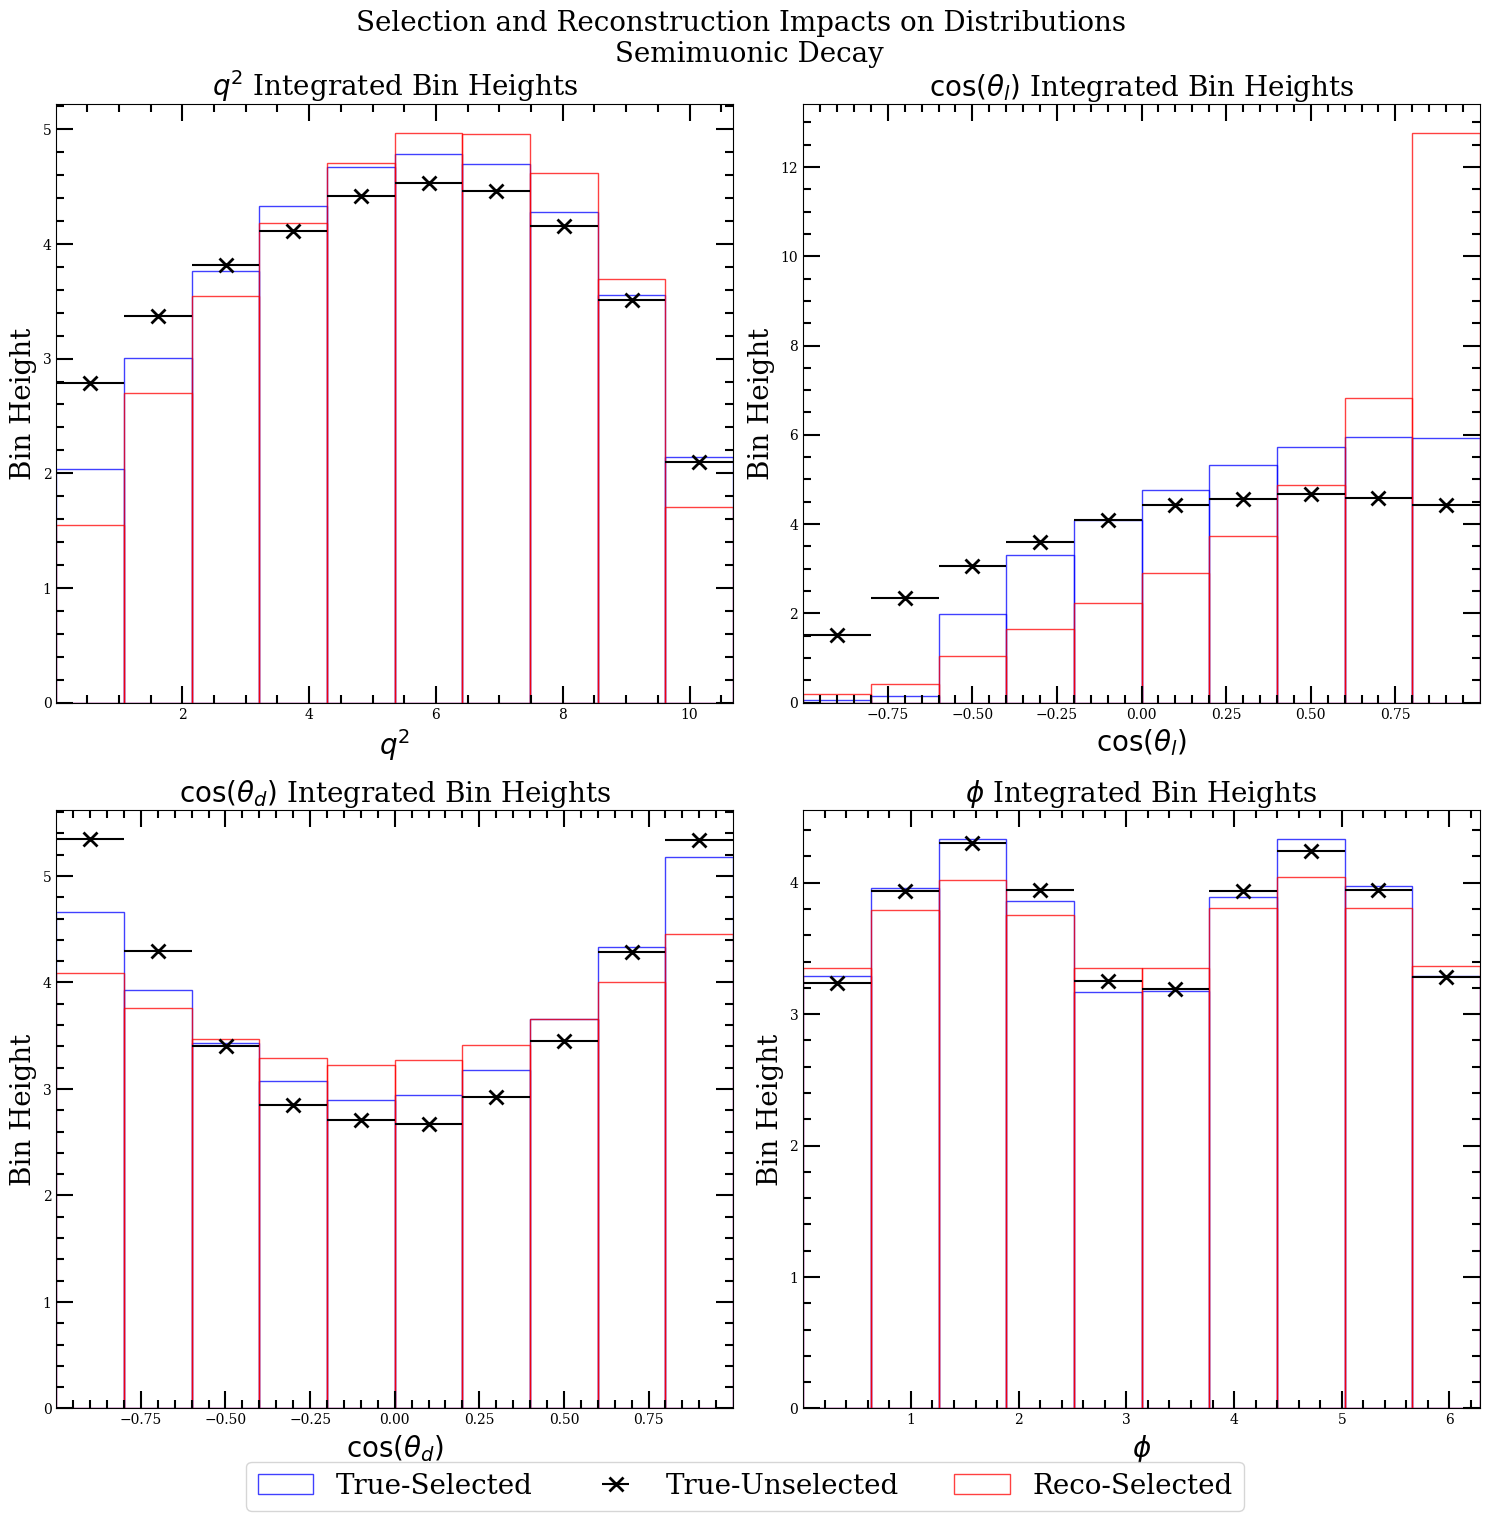

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Define datasets and titles
datasets = [results_true, results_raw, results_reco]
dataset_labels = ['True-Selected', 'True-Unselected', 'Reco-Selected']
edge_colors = ['blue', 'black', 'red']  # Different edge colors for each dataset
lbl = ['$q^2$', r'$\cos(\theta_l)$', r'$\cos(\theta_d)$', r'$\phi$']
col = results_true.columns

plt.rcParams['font.family'] = 'Serif'

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
axs = axs.flatten()

# Loop over axis elements and the columns as they are index matched
for i, column in enumerate(col[:-1]):
    ax = axs[i]
    # Loop through the three datasets
    for dataset, label, edge_color in zip(datasets, dataset_labels, edge_colors):
        # Extract the unique bin-centres for the specific observable
        x_values = np.unique(dataset[column].values)

        # Integrated over all other observables to return 1D histogram
        integrated_dataset = dataset.groupby([column])['bin_height'].sum().reset_index()
        # Extract integrated bin-heights
        integrated_heights = integrated_dataset['bin_height'].values

        # Calculate bin width
        bin_width = np.diff(np.unique(x_values))[0]

        # Plot error bars only for results_raw
        if dataset is results_raw:
            ax.errorbar(
                x=x_values,
                y=integrated_heights,
                xerr=bin_width / 2,
                fmt='x',
                markersize=10,
                markeredgewidth=2,
                color=edge_color,
                label=f'{label}'
            )
        
        else:
            ax.bar(x=x_values, height=integrated_heights, width=bin_width, color='none', edgecolor=edge_color, label=label, alpha=0.75)

    # Set title and labels
    ax.set_title(f'{lbl[i]} Integrated Bin Heights', fontsize=20)
    ax.set_xlabel(lbl[i], fontsize=20)
    ax.set_ylabel('Bin Height', fontsize=20)

    ax.set_xlim(min(x_values) - bin_width / 2, max(x_values) + bin_width / 2)

    # Add grid and ticks
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())

    if i == 0:
        handles, labels = ax.get_legend_handles_labels()

    ax.tick_params(
        axis='both',
        which='major',
        direction='in',
        right=True,
        top=True,
        length=12,
        width=1.5,
    )

    # Minor ticks: smaller and thinner
    ax.tick_params(
        axis='both',
        which='minor',
        direction='in',
        right=True,
        top=True,
        length=6,
        width=1.5,
    )

# Add a legend to the figure
fig.legend(
    handles=handles[:3],  # Ensure you pass the correct handles for the legend
    labels=labels[:3],    # Ensure you pass the correct labels for the legend
    loc='lower center',
    ncol=3,
    bbox_to_anchor=(0.5, -0.03),  # Centered at the bottom
    fontsize=20
)

fig.suptitle('Selection and Reconstruction Impacts on Distributions \n Semimuonic Decay', fontsize=20)

plt.tight_layout()
plt.show()

## Irrelevants, But Sometimes Used:

### Missing mass squared due to the undetected neutrino

In [ ]:
missing_mass_squared = invariant_mass_squared(neutrino_momentum)/1e6
missing_mass_squared = missing_mass_squared[valid_indices]
plt.hist(missing_mass_squared)
plt.title(r'$m^2_{miss}$')
plt.grid()
plt.show()

### Muon Energy in the B rest frame

In [ ]:
E_mu_B_frame = mu_B_boosted[:,0]
plt.hist(E_mu_B_frame)
plt.title(r'$E_{\mu}$')
plt.grid()
plt.show()

## Final Plotted Decay Quantities
Change file names to reco/true dpending on what being used.

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Data and titles for the plots
data = [cos_theta_l, cos_theta_d, phi, q2, missing_mass_squared, E_mu_B_frame]
titles = [r'$\cos\theta_l$', r'$\cos\theta_D$', r'$\phi$', r'$q^2$']

# Loop through the data and plot each one
for i, ax in enumerate(axs.flat):
    ax.hist(data[i])
    ax.set_xlabel(titles[i], fontsize = 14)
    

plt.tight_layout()
fig.suptitle('True variables', fontsize=16, y=1.04)
plt.savefig('true_fit_variables.png', dpi=300, bbox_inches='tight')
plt.show()

In [22]:
B_in_B = lorentz_boost_lvec(B_momentum,B_momentum, valid_indices).T

array([5279.58009694, 5279.58009694, 5279.58009694, ..., 5279.58009694,
       5279.58009694, 5279.58009694])

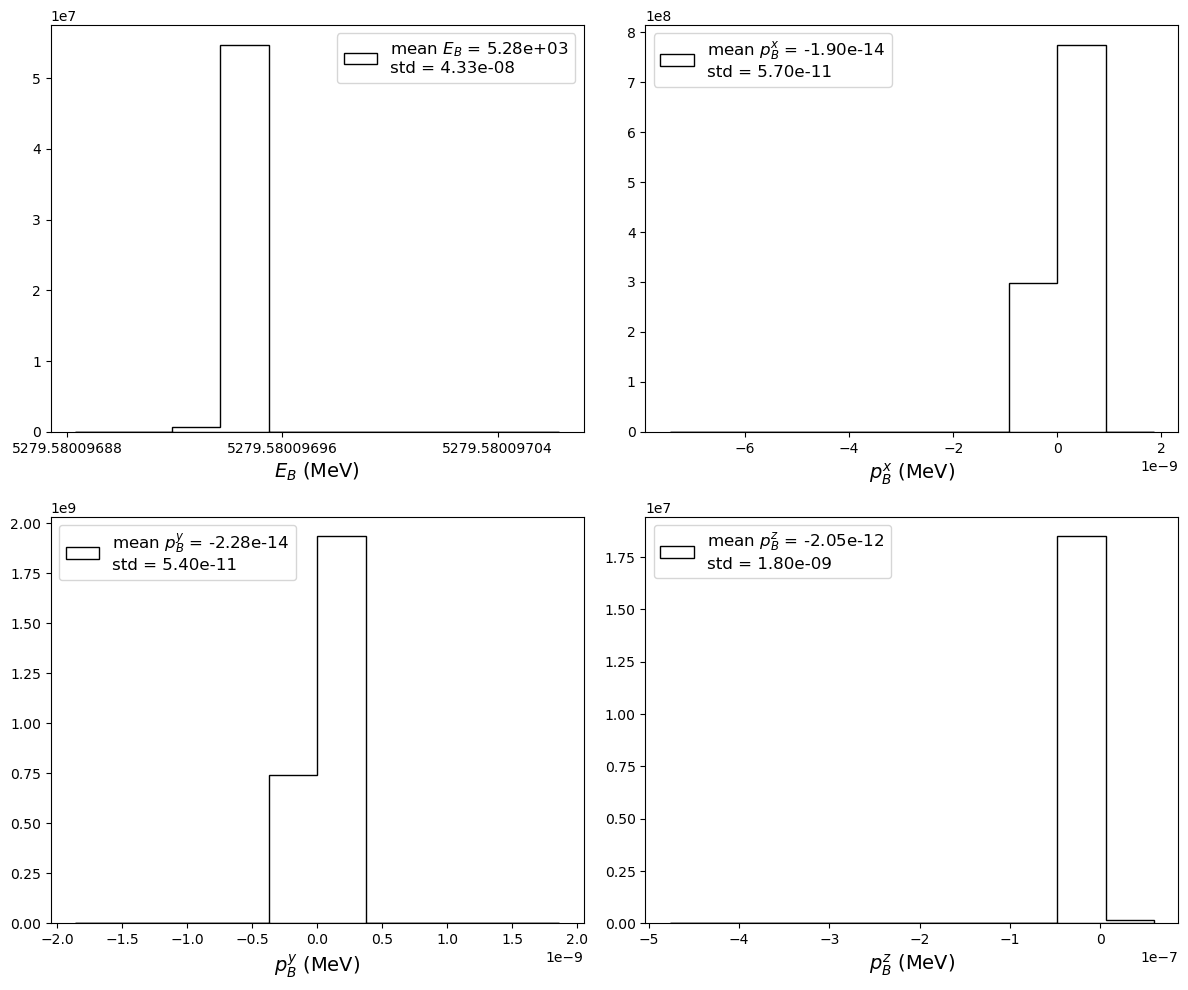

In [121]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
from matplotlib.ticker import MaxNLocator

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Helper function to format std in scientific notation
def format_mean(val):
    return f"{val:.2e}"

def format_std(val):
    return f"{val:.2e}"

# Plot for B_in_B[0]
axs[0, 0].hist(B_in_B[0], density=True, histtype='stepfilled', edgecolor='black', alpha=1, facecolor='white',
               label=fr"mean $E_B$ = {format_mean(B_in_B.mean(axis=1)[0])}" + "\n" + r"std = " + format_std(B_in_B.std(axis=1)[0]))
axs[0, 0].xaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
axs[0, 0].xaxis.set_major_locator(MaxNLocator(nbins=3))
axs[0, 0].legend(fontsize=12)
axs[0, 0].set_xlabel(r"$E_B$ (MeV)", fontsize=14)

# Plot for B_in_B[1]
axs[0, 1].hist(B_in_B[1], density=True, histtype='stepfilled', edgecolor='black', alpha=1, facecolor='white',
               label=fr"mean $p_B^x$ = {format_mean(B_in_B.mean(axis=1)[1])}" + "\n" + r"std = " + format_std(B_in_B.std(axis=1)[1]))
axs[0, 1].legend(fontsize=12)
axs[0, 1].set_xlabel(r"$p_B^x$ (MeV)", fontsize=14)

# Plot for B_in_B[2]
axs[1, 0].hist(B_in_B[2], density=True, histtype='stepfilled', edgecolor='black', alpha=1, facecolor='white',
               label=fr"mean $p_B^y$ = {format_mean(B_in_B.mean(axis=1)[2])}" + "\n" + r"std = " + format_std(B_in_B.std(axis=1)[2]))
axs[1, 0].legend(fontsize=12)
axs[1, 0].set_xlabel(r"$p_B^y$ (MeV)", fontsize=14)

# Plot for B_in_B[3]
axs[1, 1].hist(B_in_B[3], density=True, histtype='stepfilled', edgecolor='black', alpha=1, facecolor='white',
               label=fr"mean $p_B^z$ = {format_mean(B_in_B.mean(axis=1)[3])}" + "\n" + r"std = " + format_std(B_in_B.std(axis=1)[3]))
axs[1, 1].legend(fontsize=12)
axs[1, 1].set_xlabel(r"$p_B^z$ (MeV)", fontsize=14)

plt.tight_layout()
plt.savefig('B_in_B.png', dpi=300, bbox_inches='tight')
plt.show()


In [140]:
B_in_B = lorentz_boost_lvec(B_momentum,B_momentum, valid_indices).T
Dstar_in_Dstar = lorentz_boost_lvec(Dstar_momentum,Dstar_momentum, valid_indices).T
mu_in_mu = lorentz_boost_lvec(mu_momentum,mu_momentum, valid_indices).T
D0_in_D0 = lorentz_boost_lvec(D0_momentum,D0_momentum, valid_indices).T
slpi_in_slpi = lorentz_boost_lvec(slpi_momentum,slpi_momentum, valid_indices).T

In [141]:
B_in_B_mean = B_in_B.mean(axis=1)
Dstar_in_Dstar_mean = Dstar_in_Dstar.mean(axis=1)
mu_in_mu_mean = mu_in_mu.mean(axis=1)
D0_in_D0_mean = D0_in_D0.mean(axis=1)
slpi_in_slpi_mean = slpi_in_slpi.mean(axis=1)
data = {
    "B_in_B_mean": B_in_B_mean,
    "Dstar_in_Dstar_mean": Dstar_in_Dstar_mean,
    "mu_in_mu_mean": mu_in_mu_mean,
    "D0_in_D0_mean": D0_in_D0_mean,
    "slpi_in_slpi_mean": slpi_in_slpi_mean
}

df_means = pandas.DataFrame(data)
display(df_means)

,B_in_B_mean,Dstar_in_Dstar_mean,mu_in_mu_mean,D0_in_D0_mean,slpi_in_slpi_mean
0,5.279580e+03,2.010268e+03,1.056585e+02,1.864840e+03,1.394155e+02
1,-1.896519e-14,8.772953e-14,-6.653423e-13,5.330236e-14,1.025459e-15
2,-2.282337e-14,-4.945051e-14,1.758461e-13,-5.005934e-14,2.271669e-15
3,-2.047930e-12,-2.319322e-14,-1.729771e-11,-4.096761e-13,-7.242906e-14


In [125]:
B_in_B = lorentz_boost_lvec(B_momentum,B_momentum, valid_indices)
Dstar_in_B = lorentz_boost_lvec(Dstar_momentum,B_momentum, valid_indices)
mu_in_B = lorentz_boost_lvec(mu_momentum,B_momentum, valid_indices)
D0_in_B = lorentz_boost_lvec(D0_momentum,B_momentum, valid_indices)
slpi_in_B = lorentz_boost_lvec(slpi_momentum,B_momentum, valid_indices)

B_in_Dstar = lorentz_boost_lvec(B_momentum,Dstar_momentum, valid_indices)
Dstar_in_Dstar = lorentz_boost_lvec(Dstar_momentum,Dstar_momentum, valid_indices)
mu_in_Dstar = lorentz_boost_lvec(mu_momentum,Dstar_momentum, valid_indices)
D0_in_Dstar = lorentz_boost_lvec(D0_momentum,Dstar_momentum, valid_indices)
slpi_in_Dstar = lorentz_boost_lvec(slpi_momentum,Dstar_momentum, valid_indices)


In [128]:
p2B_in_B = np.sqrt(invariant_mass_squared(B_in_B))
p2Dstar_in_B = np.sqrt(invariant_mass_squared(Dstar_in_B))
p2mu_in_B = np.sqrt(invariant_mass_squared(mu_in_B))
p2D0_in_B = np.sqrt(invariant_mass_squared(D0_in_B))
p2slpi_in_B = np.sqrt(invariant_mass_squared(slpi_in_B))

p2B_in_Dstar = np.sqrt(invariant_mass_squared(B_in_Dstar))
p2Dstar_in_Dstar = np.sqrt(invariant_mass_squared(Dstar_in_Dstar))
p2mu_in_Dstar = np.sqrt(invariant_mass_squared(mu_in_Dstar))
p2D0_in_Dstar = np.sqrt(invariant_mass_squared(D0_in_Dstar))
p2slpi_in_Dstar = np.sqrt(invariant_mass_squared(slpi_in_Dstar))


In [ ]:
mean_df = pandas.DataFrame({
    "B ": [p2B_in_B.mean(), p2B_in_Dstar.mean()],
    "Dstar": [p2Dstar_in_B.mean(), p2Dstar_in_Dstar.mean()],
    "mu": [p2mu_in_B.mean(), p2mu_in_Dstar.mean()],
    "D0": [p2D0_in_B.mean(), p2D0_in_Dstar.mean()],
    "slpi": [p2slpi_in_B.mean(), p2slpi_in_Dstar.mean()],
})
mean_df.index = ["B Frame", "Dstar Frame"]
display(mean_df)


## Plotting Out NN Performances Here:

,val_losses,train_losses
0,0.579365,0.659759
1,0.512965,0.473608
2,0.466344,0.443413
3,0.443181,0.414037
4,0.419105,0.391858
...,...,...
58,0.132456,0.119536
59,0.134085,0.121816
60,0.136714,0.122281
61,0.126251,0.119578


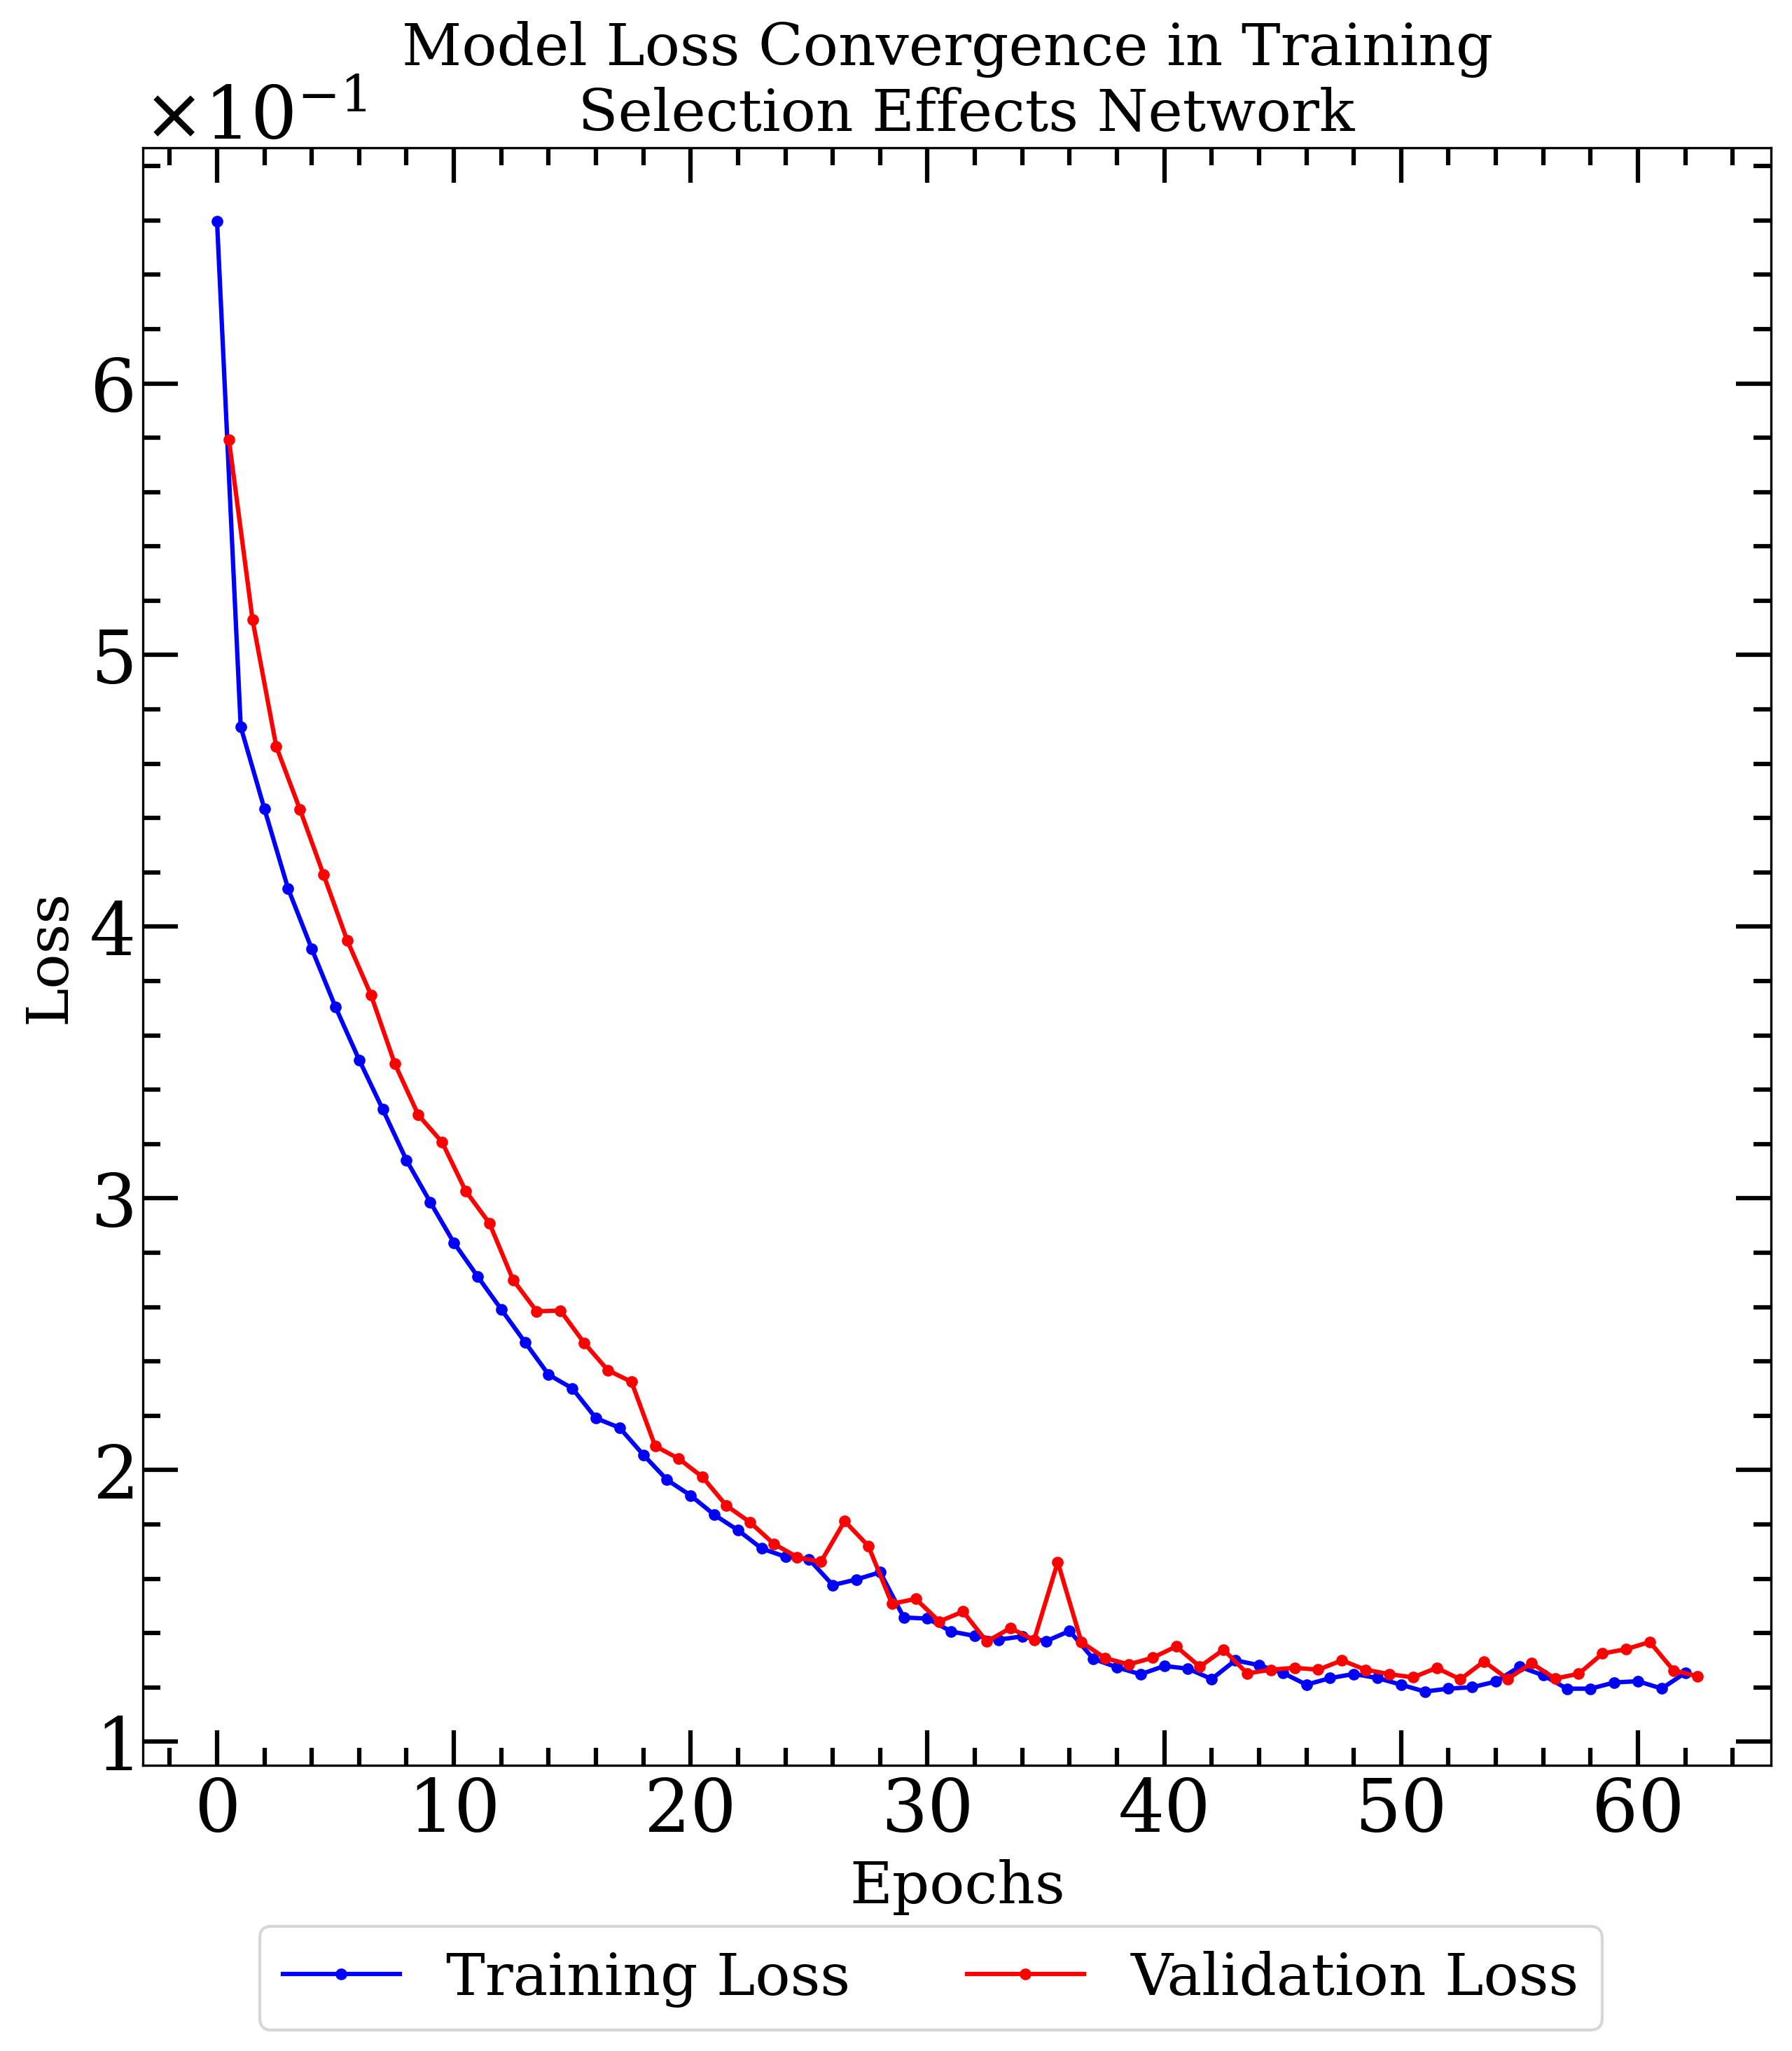

In [101]:
data_pth = 'raw_data/losses_geant_network.csv'
geant_loss = pd.read_csv(data_pth)

epochs = geant_loss.index

select_pth = 'raw_data/losses_selection_network.csv'
select_loss = pd.read_csv(select_pth)
epochs_select = select_loss.index

idx = 0

import matplotlib.ticker as ticker

fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=300)
plt.rcParams["font.family"] = "Serif"
plt.rcParams['font.size'] = 15
ax.plot(epochs, geant_loss['train_losses'].values, 'o-', markersize=3,  color='blue', label='Training Loss')
ax.plot(epochs + 0.5, geant_loss['val_losses'].values, 'o-', markersize=3, color='red', label='Validation Loss')

ax.set_xlabel('Epochs', fontsize=20,)
ax.set_ylabel('Loss', fontsize=20,)
ax.set_title('Model Loss Convergence in Training \n Selection Effects Network', fontsize=20)

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((0, 0))  # Forces scientific notation with x10^4
ax.yaxis.set_major_formatter(formatter)

ax.tick_params(
            axis='both',
            which='major',
            direction='in',
            length=12,
            right=True,
            top=True,
            width=1.5,
        )

ax.tick_params(
            axis='both',
            which='minor',
            direction='in',
            length=6,
            right=True,
            top=True,
            width=1.5,
        )

handles, labels = ax.get_legend_handles_labels()

fig.legend(
        handles=handles,  # Ensure you pass the correct handles for the legend
        labels=labels,    # Ensure you pass the correct labels for the legend
        loc='lower center',
        ncol=4,
        bbox_to_anchor=(0.5, -0.03),  # Centered at the bottom
        fontsize=20
    )

display(geant_loss)

Normalized area under the histogram: 1.0


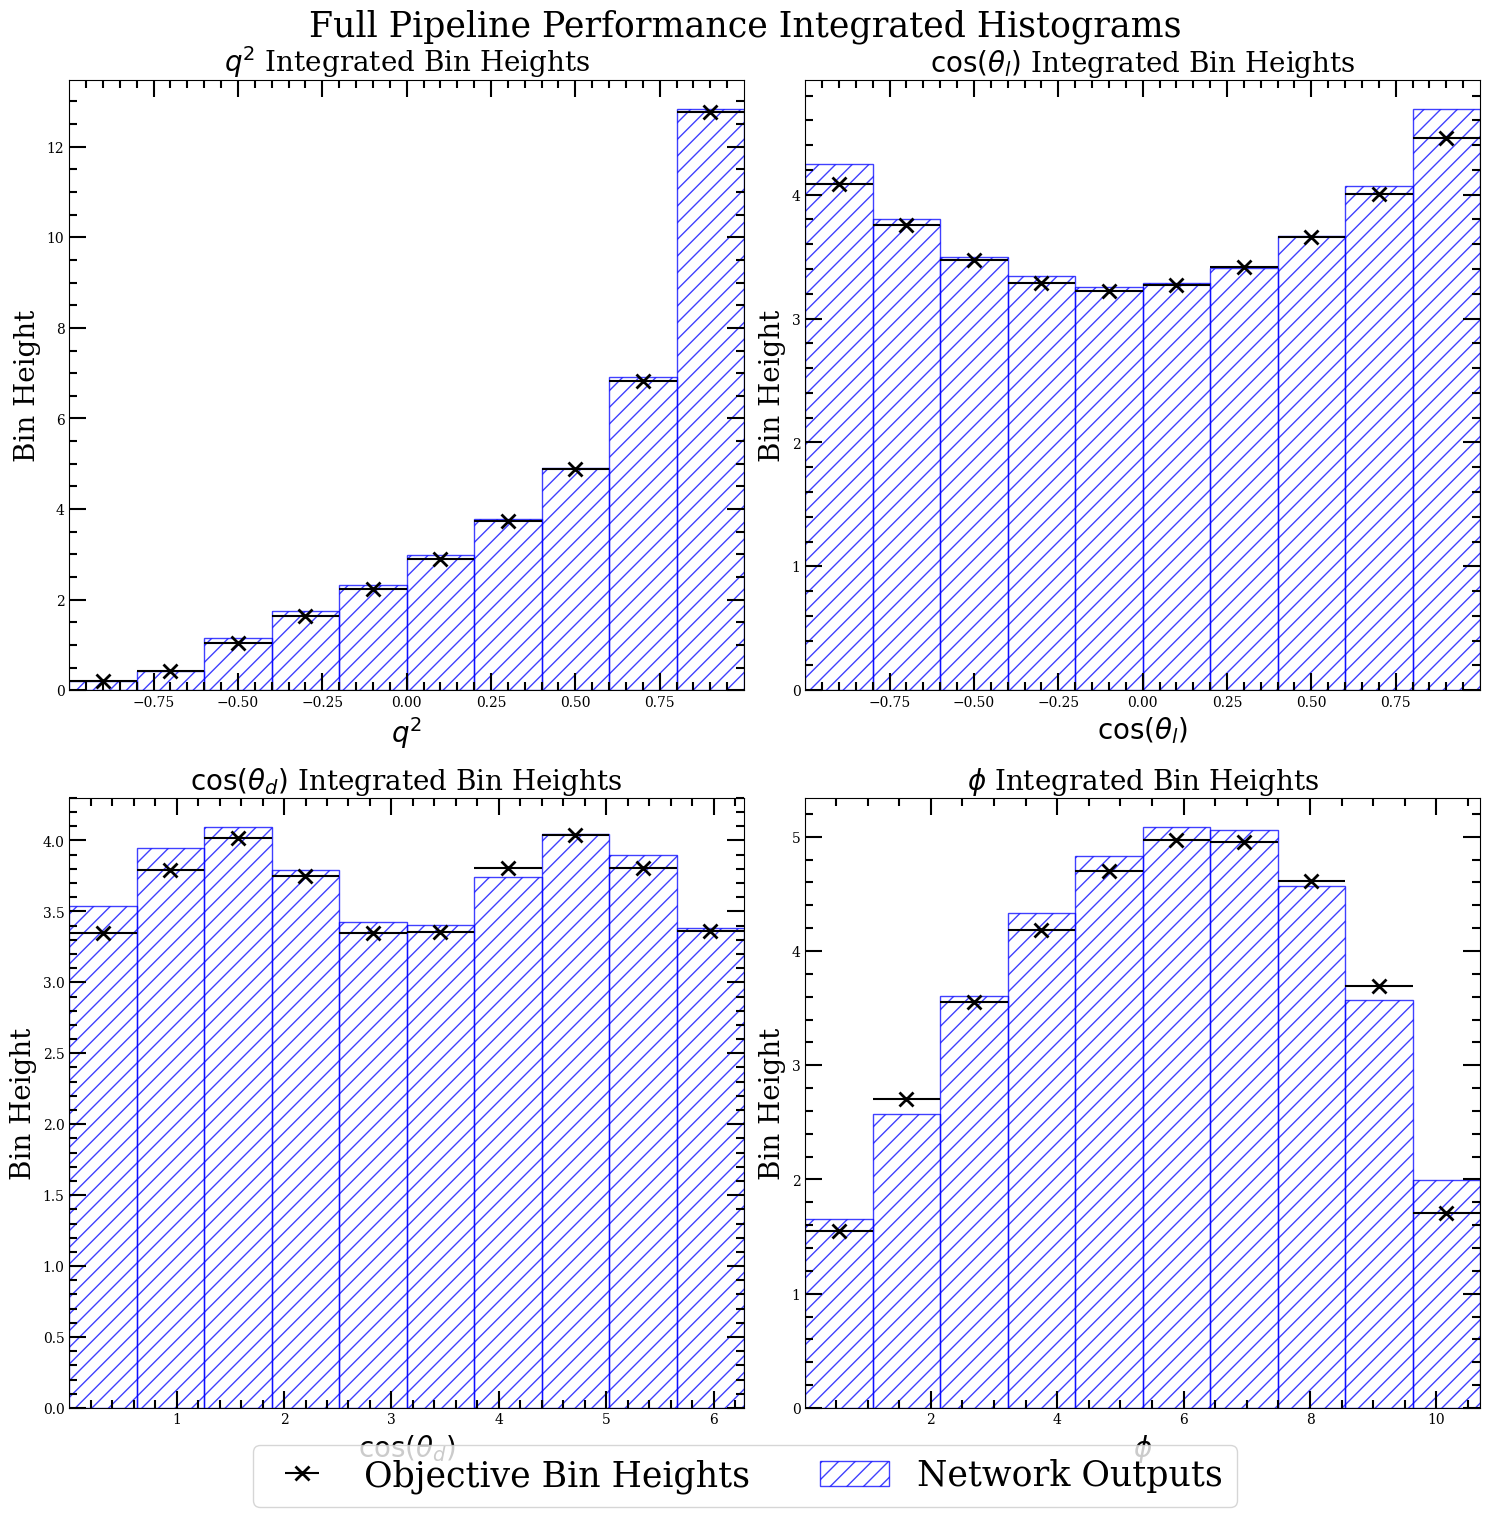

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

perf_pth = 'raw_data/full_geant_smearing.csv'
# obj_pth = 'raw_data/selection_test_set.csv'

r = []

dataset = pd.read_csv(perf_pth)
bin_widths = [
    np.diff(np.unique(dataset[column].values))[0] for column in dataset.columns[:-1]
]

# Compute the total area under the histogram
total_area = dataset['bin_height'].sum() * np.prod(bin_widths)

# Normalize the bin heights
dataset['bin_height'] /= total_area

normalized_area = dataset['bin_height'].sum() * np.prod(bin_widths)
print(f"Normalized area under the histogram: {normalized_area}")

obj_set = results_reco

lbl = ['$q^2$', r'$\cos(\theta_l)$', r'$\cos(\theta_d)$', r'$\phi$']
col = dataset.columns

plt.rcParams['font.family'] = 'Serif'

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
axs = axs.flatten()

# Loop over axis elements and the columns as they are index matched
for i, column in enumerate(col[:-1]):
    ax = axs[i]

    x_values = np.unique(dataset[column].values)

    integrated_dataset = dataset.groupby([column])['bin_height'].sum().reset_index()
    integrated_heights = integrated_dataset['bin_height'].values

    bin_width = np.diff(np.unique(x_values))[0]

    obj_integrated = obj_set.groupby([column])['bin_height'].sum().reset_index()
    obj_heights = obj_integrated['bin_height'].values

    yerr = np.sqrt(obj_heights)

    ax.errorbar(
        x=x_values,
        y=obj_heights,
        xerr=bin_width / 2,
        fmt='x',
        markersize=10,
        markeredgewidth=2,
        color='black',
        label='Objective Bin Heights'
    )

    r_squared = r2_score(obj_heights, integrated_heights)
    r.append(r_squared)

    
    ax.bar(x=x_values, height=integrated_heights, width=bin_width, color='none', hatch='//', edgecolor='blue', label="Network Outputs", alpha=0.75)

    ax.set_title(f'{lbl[i]} Integrated Bin Heights', fontsize=20)
    ax.set_xlabel(lbl[i], fontsize=20)
    ax.set_ylabel('Bin Height', fontsize=20)

    ax.set_xlim(min(x_values) - bin_width / 2, max(x_values) + bin_width / 2)


    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())

    if i == 0:
        handles, labels = ax.get_legend_handles_labels()

    ax.tick_params(
        axis='both',
        which='major',
        direction='in',
        right=True,
        top=True,
        length=12,
        width=1.5,
    )

    # Minor ticks: smaller and thinner
    ax.tick_params(
        axis='both',
        which='minor',
        direction='in',
        right=True,
        top=True,
        length=6,
        width=1.5,
    )

# Add a legend to the figure
fig.legend(
    handles=handles[:3],  # Ensure you pass the correct handles for the legend
    labels=labels[:3],    # Ensure you pass the correct labels for the legend
    loc='lower center',
    ncol=3,
    bbox_to_anchor=(0.5, -0.03),  # Centered at the bottom
    fontsize=25
)

fig.suptitle('Full Pipeline Performance Integrated Histograms', fontsize=25)


plt.tight_layout()
plt.show()

In [15]:
print(np.mean(r), np.std(r))

0.9497439518954149 0.04880716233068658


In [ ]:
from sklearn.metrics import r2_score

# Extract predicted and objective bin heights
predicted = dataset['bin_height'].values
objective = results_reco['bin_height'].values

# Calculate R-squared score
r_squared = r2_score(objective, predicted)

print(f"R-squared score: {r_squared:.4f}")

In [2]:
import numpy as np
import matplotlib.pyplot as plt


def QQ_Plot(prediction, objective):
    """
    Generates a QQ plot comparing predicted and actual Wilson coefficients,
    including reflections where necessary and fitting a trend line.

    Parameters
    ----------
    prediction : list or np.ndarray
        List or array of predicted Wilson coefficients.
    objective : list or np.ndarray
        List or array of actual Wilson coefficients.
    """
    # Convert lists to NumPy arrays
    obj_vals = np.array(objective)
    pred_vals = np.array(prediction)

    sorted_pairs = sorted(zip(obj_vals, pred_vals))
    obj_vals, pred_vals = np.array(sorted_pairs).T

    # Fit the new trend line using updated predictions
    pred_coeffs = np.polyfit(obj_vals, pred_vals, 1)
    pred_func = np.poly1d(pred_coeffs)

    plt.rcParams["font.family"] = "Serif"
    plt.rcParams['font.size'] = 25

    fig_1, axs_1 = plt.subplots(1, 1, figsize=(15, 15), dpi=200)

    sorted_obj = sorted(obj_vals)

    error_region = np.sqrt(sorted_obj)

    lower_bound = obj_vals - error_region
    upper_bound = obj_vals + error_region

    within_region = (pred_vals >= lower_bound) & (pred_vals <= upper_bound)
    percentage_within = np.mean(within_region) * 100
    print(f"Percentage of predictions within the statistical variation region: {percentage_within:.2f}%")

    axs_1.fill_between(
        sorted_obj, 
        sorted_obj - error_region, 
        sorted_obj + error_region, 
        color='lightgray', 
        alpha=0.4, 
        label='Statistical Variability'
        )

    axs_1.plot(obj_vals, pred_vals, 'o', label='Detector-Smeared Amount Prediction', color='blue')
    axs_1.plot(sorted_obj, pred_func(sorted_obj), linestyle='dashed', label=f'Gradient: {pred_coeffs[0]:.2f}, Offset {pred_coeffs[1]:.2f}', color='gray')
    
    axs_1.set_xlim(np.min([obj_vals, pred_vals]), np.max([obj_vals, pred_vals]))
    axs_1.set_ylim(np.min([obj_vals, pred_vals]), np.max([obj_vals, pred_vals]))

    coords_x = [0, np.max(obj_vals)]
    coords_y = [0, np.max(obj_vals)]

    axs_1.plot(coords_x, coords_y, color='red', label='Perfect Performance Axis')

    axs_1.xaxis.set_minor_locator(AutoMinorLocator())
    axs_1.yaxis.set_minor_locator(AutoMinorLocator())

    axs_1.set_xlabel('Actual Bin-Heights')
    axs_1.set_ylabel('Predicted Bin-Heights')

    axs_1.tick_params(axis='both', which='major', direction='in', right=True, top=True, length=12, width=1.5)
    axs_1.tick_params(axis='both', which='minor', direction='in', right=True, top=True, length=6, width=1.5)
    
    fig_1.suptitle('Detector Effects Network Performance \n Semimuonic Decay')

    handles, labels = axs_1.get_legend_handles_labels()    

    fig_1.legend(
    handles=handles[:4],  # Ensure you pass the correct handles for the legend
    labels=labels[:4],    # Ensure you pass the correct labels for the legend
    loc='lower center',
    ncol=2,
    bbox_to_anchor=(0.5, -0.05),  # Centered at the bottom
    fontsize=20
    )    

    plt.tight_layout()


Percentage of predictions within the statistical variation region: 97.20%


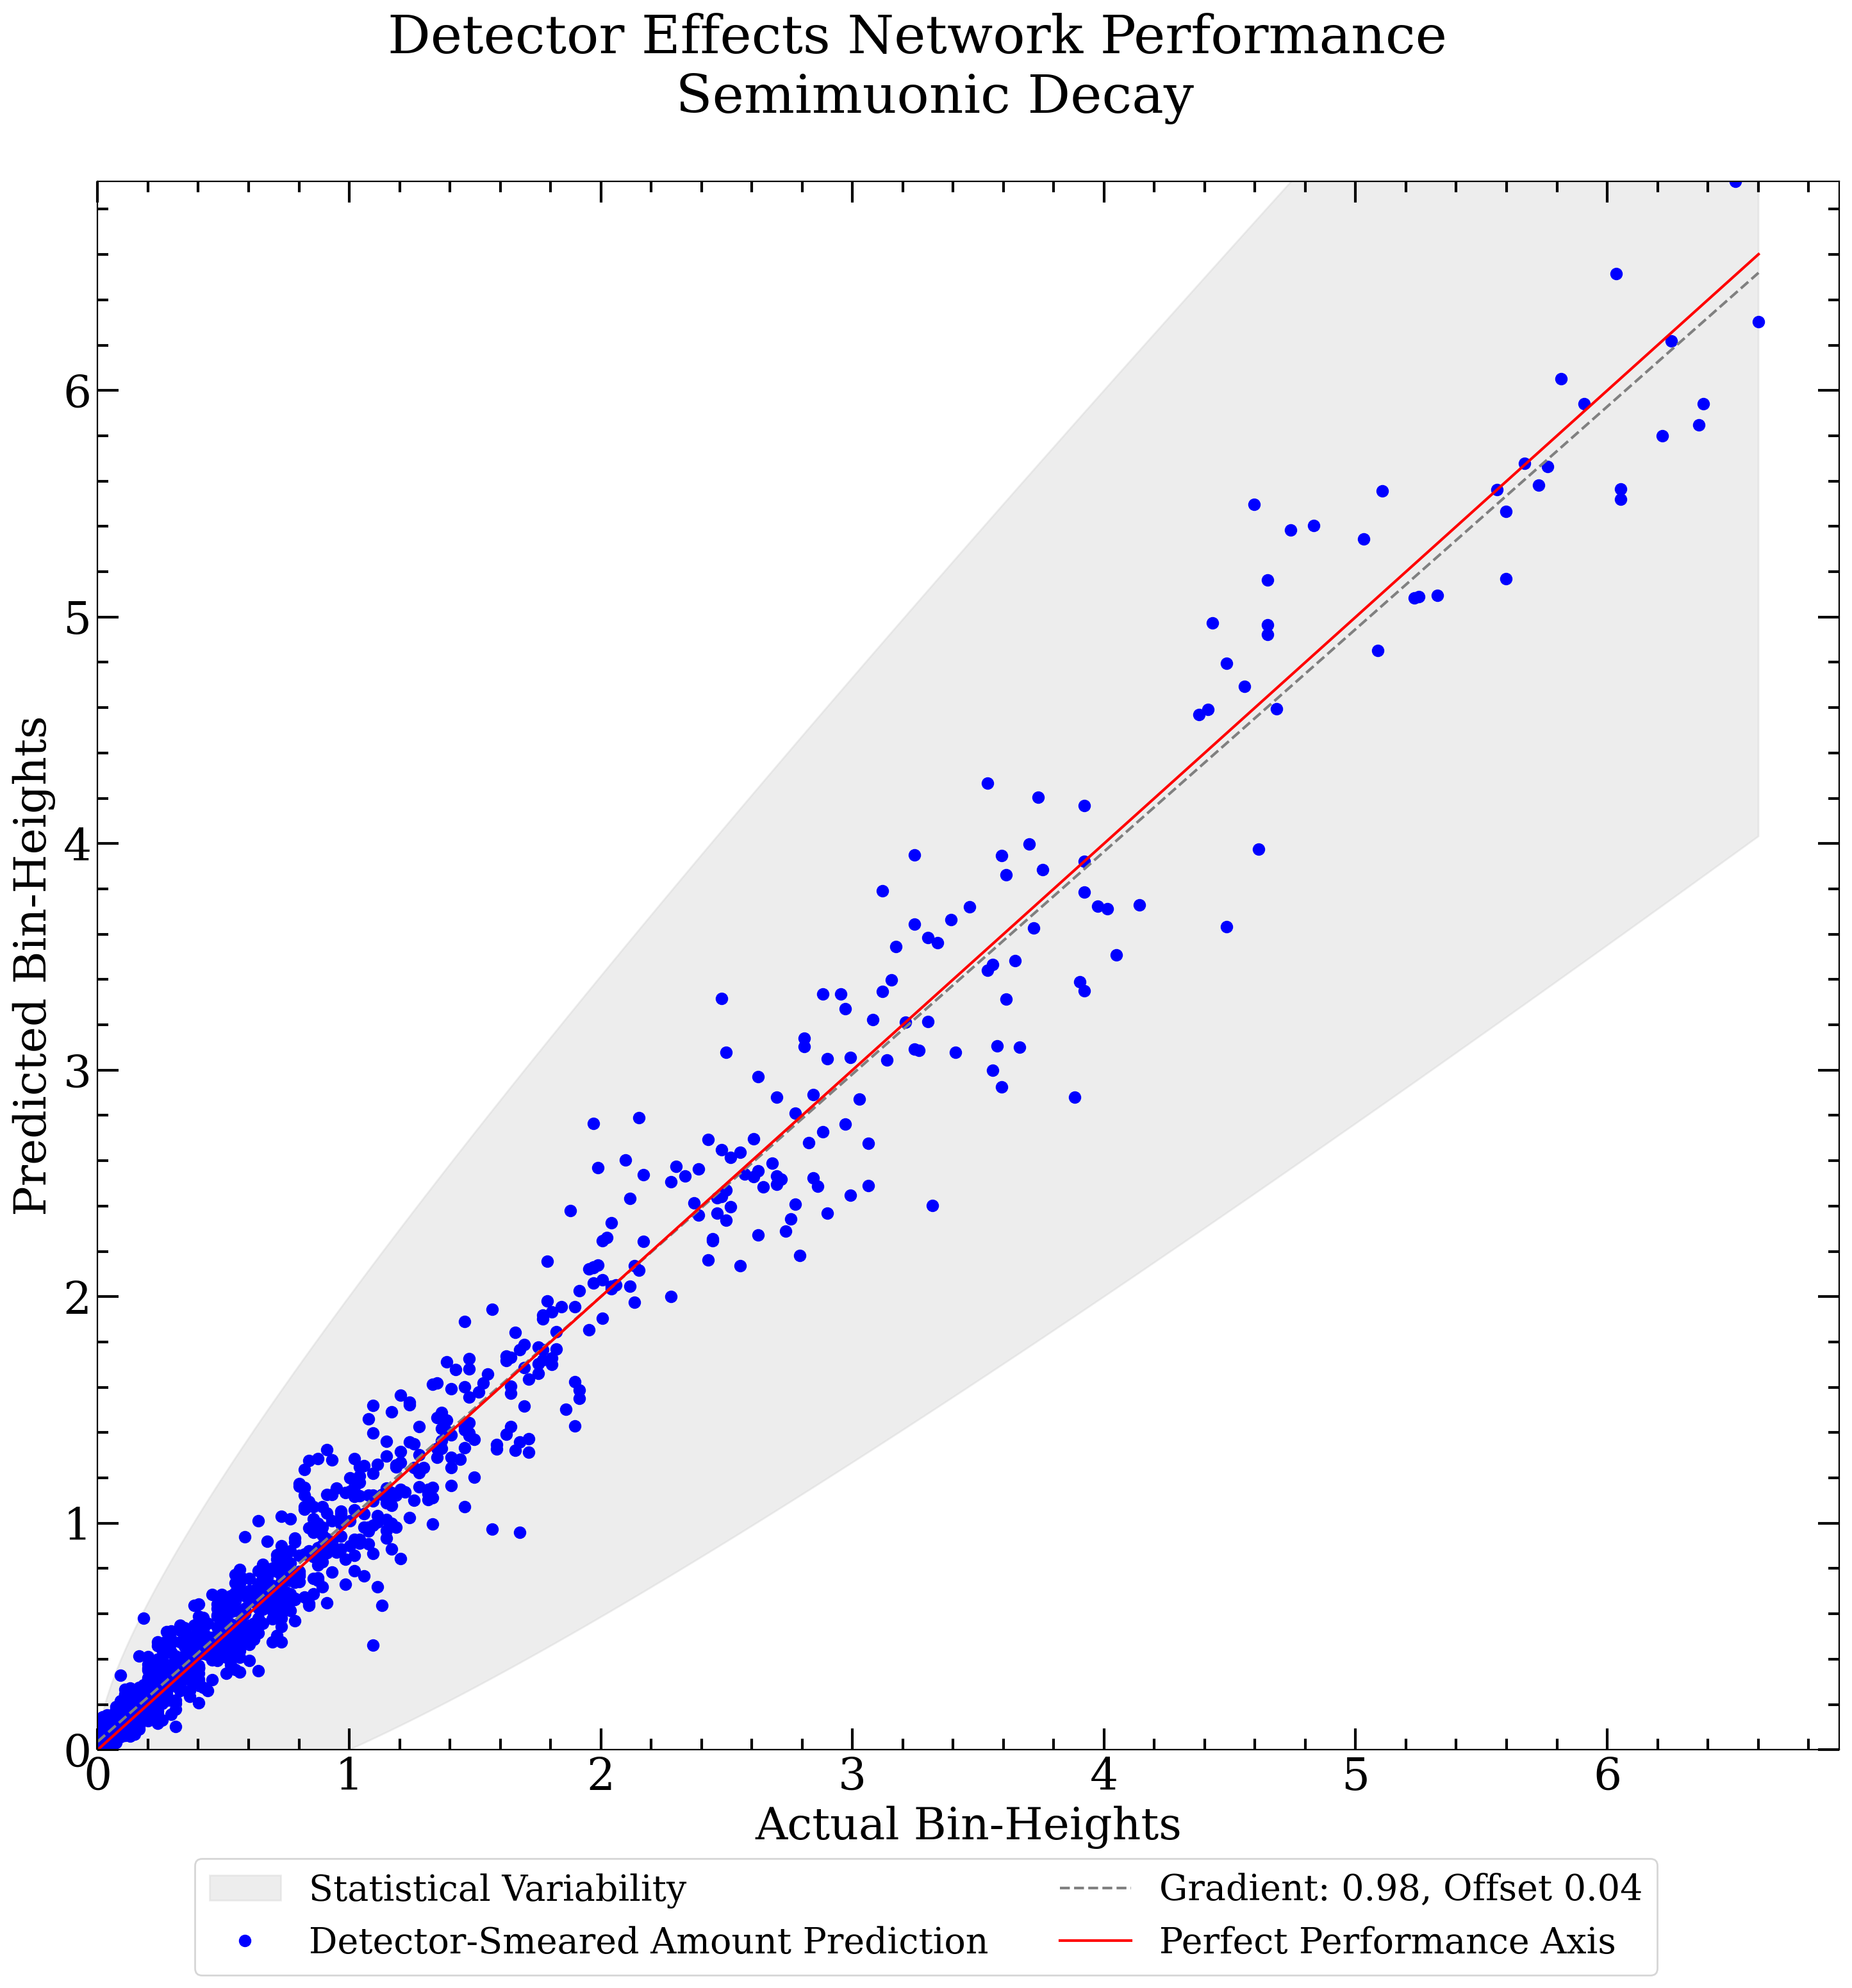

In [3]:
perf_pth = 'raw_data/geant_test_set_predictions.csv'
obj_pth = 'raw_data/geant_test_set.csv'

dataset = pd.read_csv(perf_pth)
obj_set = pd.read_csv(obj_pth)

QQ_Plot(dataset['bin_height'].values, obj_set['bin_height'].values)